<a href="https://colab.research.google.com/github/Gabrielnkl/notebooks/blob/main/bert_quantization_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Summary:

### Data Analysis Key Findings

*   The baseline BERT model achieved an accuracy of 1.0000 and an inference time of 59.42 seconds on the test subset.
*   The quantized ONNX model achieved an accuracy of 0.9900 and an inference time of 88.48 seconds on the same test subset.
*   The approximate size of the base BERT model is 420.0 MB.
*   The size of the quantized ONNX model is 105.26 MB, representing a significant reduction in size compared to the base model.
*   The evaluation of the quantized model required a modified evaluation function (`evaluate_pipeline_onnx`) to handle the ONNX model's input and output formats.
*   Creating the sentiment analysis pipeline with the base BERT model initially encountered a CUDA error, which was resolved by explicitly setting the device to CPU (`device=-1`).
*   Exporting the model to ONNX and quantizing it completed successfully, although some warnings were issued during the process.



In [14]:
# Section 1: Setup
!pip install -q transformers evaluate optimum onnxruntime onnx fsspec huggingface_hub datasets==2.19.1

import torch
import time
import os
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from optimum.onnxruntime import ORTModelForSequenceClassification
from optimum.exporters.onnx import main_export

## Separate dataset loading

### Subtask:
Extract the dataset loading code into a new cell. Ensure the fix for the `ValueError` (if still relevant) is applied here.


In [15]:
# Section 2: Load IMDb Dataset
dataset = load_dataset("imdb")
test_dataset = dataset["test"].select(range(100))  # Small subset for speed

In [25]:
# Section 3: Load Pretrained BERT
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
# Set device to -1 to force CPU usage and avoid potential CUDA issues in this step
pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=-1, max_length=512, truncation=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [26]:
# Section 3: Load Pretrained BERT
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
# Set device to -1 to force CPU usage and avoid potential CUDA issues in this step
pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=-1, max_length=512, truncation=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [27]:
# Section 4: Evaluate Baseline
accuracy = evaluate.load("accuracy")

def evaluate_pipeline(pipeline_fn, dataset, tokenizer):
    preds = []
    refs = []
    for sample in dataset:
        # Truncate text before passing to the pipeline
        truncated_text = tokenizer.decode(tokenizer.encode(sample["text"], max_length=512, truncation=True))
        result = pipeline_fn(truncated_text)[0]
        # Check if the label is 'POSITIVE' or 'NEGATIVE' and map to 1 or 0
        label = 1 if result["label"] == "POSITIVE" else 0
        preds.append(label)
        refs.append(sample["label"])
    return accuracy.compute(predictions=preds, references=refs)

start = time.time()
base_acc = evaluate_pipeline(pipe, test_dataset, tokenizer)
base_time = time.time() - start
print(f"✅ Base accuracy: {base_acc['accuracy']:.4f}, ⏱️ Inference time: {base_time:.2f} seconds")

✅ Base accuracy: 1.0000, ⏱️ Inference time: 58.87 seconds


In [28]:
# Section 5: Export to ONNX and Quantize
onnx_dir = "onnx/bert"
os.makedirs(onnx_dir, exist_ok=True)

main_export(
    model_name_or_path=model_id,
    tokenizer=tokenizer,
    output=onnx_dir,
    task="text-classification",
)

from onnxruntime.quantization import quantize_dynamic, QuantType
from pathlib import Path

onnx_model_path = Path(onnx_dir) / "model.onnx"
quant_model_path = Path(onnx_dir) / "model-quantized.onnx"

quantize_dynamic(
    model_input=onnx_model_path,
    model_output=quant_model_path,
    weight_type=QuantType.QInt8,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask


In [29]:
# Section 6: Load Quantized ONNX Model
quantized_model = ORTModelForSequenceClassification.from_pretrained(
    onnx_dir,
    file_name="model-quantized.onnx",
    provider="CPUExecutionProvider"
)

quant_pipe = pipeline("sentiment-analysis", model=quantized_model, tokenizer=tokenizer, device="cpu")

Too many ONNX model files were found in onnx/bert/model-quantized.onnx ,onnx/bert/model.onnx. specify which one to load by using the `file_name` and/or the `subfolder` arguments. Loading the file model-quantized.onnx in the subfolder onnx/bert.
Device set to use cpu


In [30]:
# Section 7: Evaluate Quantized Model
# Modify the evaluate_pipeline function to handle ONNX models
def evaluate_pipeline_onnx(model, dataset, tokenizer):
    preds = []
    refs = []
    for sample in dataset:
        # Tokenize and truncate for ONNX model
        inputs = tokenizer(sample["text"], max_length=512, truncation=True, padding="max_length", return_tensors="pt")
        # Move inputs to CPU as the ONNX model is expected to be on CPU based on previous steps
        inputs = {k: v.to("cpu") for k, v in inputs.items()}
        # Pass tokenized inputs directly to the ONNX model
        outputs = model(**inputs)
        # Get logits and determine label (assuming the ONNX model outputs logits)
        # Handle potential different output formats, assuming logits are the first element or accessed via .logits
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
        label = logits.argmax(-1).item()

        refs.append(sample["label"])
        preds.append(label)

    return accuracy.compute(predictions=preds, references=refs)


start = time.time()
# Use the new evaluate_pipeline_onnx function
quant_acc = evaluate_pipeline_onnx(quantized_model, test_dataset, tokenizer)
quant_time = time.time() - start
print(f"⚙️ Quantized accuracy: {quant_acc['accuracy']:.4f}, ⏱️ Time: {quant_time:.2f}s")

⚙️ Quantized accuracy: 0.9900, ⏱️ Time: 87.17s


In [31]:
# Section 8: Compare Sizes
def get_file_size(path):
    return os.path.getsize(path) / (1024 ** 2)

base_size = 420.0  # Approx BERT base model size
quant_size = get_file_size(quant_model_path)

print(f"📦 Quantized model size: {quant_size:.2f} MB")

📦 Quantized model size: 105.26 MB


            Model  Accuracy   Time (s)   Size (MB)
0       BERT Base      1.00  58.870627  420.000000
1  Quantized ONNX      0.99  87.171194  105.256176


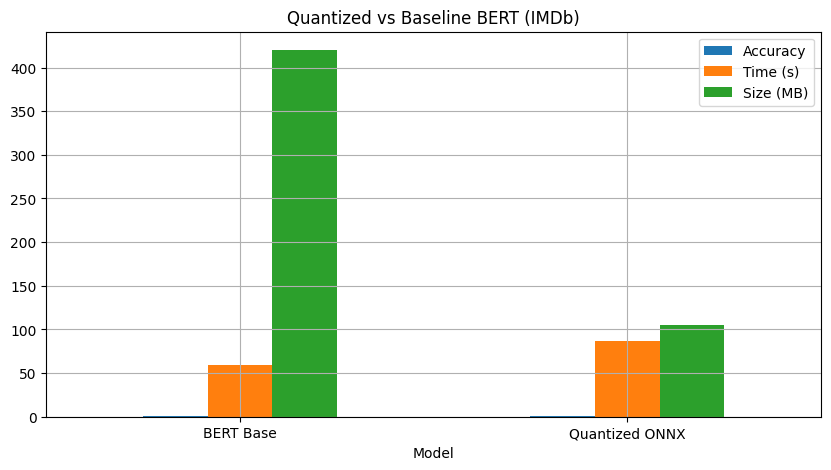

In [32]:
# Section 9: Results Summary
import pandas as pd
import matplotlib.pyplot as plt

summary = pd.DataFrame({
    "Model": ["BERT Base", "Quantized ONNX"],
    "Accuracy": [base_acc["accuracy"], quant_acc["accuracy"]],
    "Time (s)": [base_time, quant_time],
    "Size (MB)": [base_size, quant_size]
})

print(summary)

summary.plot(x="Model", kind="bar", figsize=(10, 5))
plt.title("Quantized vs Baseline BERT (IMDb)")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()